In [4]:
# Mount Google Drive (optional, if you need to save/load data)
from google.colab import drive
drive.mount('/content/drive')

# Define file path
f_path = '/content/drive/MyDrive/DiTing2.0/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision
!pip install deepwave
import deepwave
import matplotlib.pyplot as plt
from deepwave import scalar
import datetime

import pickle
import numpy as np

In [6]:
#@title Generate random velocity model

class SeismicConfig:
    """Configuration class for seismic modeling"""
    def __init__(
        self,
        model_dims=(128, 128, 128),
        v0: float = 1500.0,  # Background velocity
        v_min: float = 1500.0,  # Minimum velocity
        v_max: float = 4500.0,  # Maximum velocity
        dv: float = 500.0,  # Velocity variation
    ):
        self.model_dims = model_dims
        self.v0 = v0
        self.v_min = v_min
        self.v_max = v_max
        self.dv = dv

def create_velocity_model(
    cfg: SeismicConfig,
    device: torch.device,
    seed: int = None):
    """
    Generates 3D velocity model with realistic geological features

    Features:
    - Horizon layers with natural undulations
    - Curved layers with varying thickness
    - Complex salt bodies

    Args:
        cfg: Configuration object containing model parameters
        device: Computation device (CPU/GPU)
        seed: Random seed for reproducibility (default: None)

    Returns:
        3D velocity tensor with shape (nx, ny, nz)
    """
    # Set random seed if provided
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    nx, ny, nz = cfg.model_dims

    # Initialize base velocity model
    velocity = torch.full(cfg.model_dims, cfg.v0, device=device)

    # Create coordinate grids
    X, Y, Z = torch.meshgrid(
        torch.arange(nx, device=device),
        torch.arange(ny, device=device),
        torch.arange(nz, device=device),
        indexing='ij'
    )

    # Generate horizon layers with undulations
    num_layers = torch.randint(4, 8, (1,)).item()
    for i in range(num_layers):
        # Layer depth function with undulations
        depth_base = (i + 1) * nz // (num_layers + 1)

        # Add undulations using combination of sine waves
        undulation = (
            10 * torch.sin(2 * np.pi * X[:,:,0] / nx * torch.rand(1, device=device)) +
            10 * torch.cos(2 * np.pi * Y[:,:,0] / ny * torch.rand(1, device=device)) +
            5 * torch.sin(4 * np.pi * (X[:,:,0] + Y[:,:,0]) / (nx + ny))
        )

        # Add curved component
        curve = 0.1 * ((X[:,:,0] - nx/2)**2 + (Y[:,:,0] - ny/2)**2) / (nx * ny)

        # Create layer depth map (2D)
        layer_depth = depth_base + undulation + curve

        # Create 3D layer mask
        base_vel = 2000 + i * 200 + torch.randn(1, device=device) * 100

        for i_x in range(nx):
            for i_y in range(ny):
                depth = int(layer_depth[i_x, i_y].item())
                if depth < nz:  # Ensure depth is within bounds
                    velocity[i_x, i_y, depth:] = base_vel

    # Add salt bodies with complex shapes
    num_salt = torch.randint(1, 3, (1,)).item()
    for _ in range(num_salt):
        # Salt body center and dimensions
        x0 = torch.randint(nx//4, 3*nx//4, (1,), device=device).item()
        y0 = torch.randint(ny//4, 3*ny//4, (1,), device=device).item()
        z0 = torch.randint(nz//3, 2*nz//3, (1,), device=device).item()

        rx = torch.randint(10, max(11, nx//5), (1,), device=device).item()
        ry = torch.randint(10, max(11, ny//5), (1,), device=device).item()
        rz = torch.randint(10, max(11, nz//5), (1,), device=device).item()

        # Create salt body with basic ellipsoidal shape
        salt_mask = ((X - x0)**2/rx**2 + (Y - y0)**2/ry**2 + (Z - z0)**2/rz**2) < 1.0

        # Set salt velocity (typically around 4500 m/s)
        velocity[salt_mask] = 4500 + torch.randn(1, device=device) * 100

    # Ensure velocity is within realistic bounds
    return torch.clamp(velocity, cfg.v_min, cfg.v_max)



# Create configuration
cfg = SeismicConfig(
    model_dims=(300, 300, 300),
    v0=1500.0,
    v_min=1500.0,
    v_max=4500.0,
    dv=500.0
)

# Generate velocity model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# velocity_model = create_velocity_model(cfg, device, 0) # [128,128,128]


In [7]:
#@title magnetic
import numpy as np
from scipy.ndimage import gaussian_filter

def velocity_to_density(velocity):
    """Convert velocity to density using empirical relationships like Gardner's equation"""
    # Gardner's equation: ρ = a * v^b
    # where a=0.31, b=0.25 when v is in m/s and ρ in g/cm³
    a = 0.31
    b = 0.25
    return a * (velocity ** b)

def density_to_susceptibility(density, random_factor=0.2):
    """
    Convert density to magnetic susceptibility using a simplified relationship
    with some randomness to simulate natural variations.
    Works with both NumPy arrays and PyTorch tensors.
    """
    # Check if input is a PyTorch tensor
    is_torch = torch.is_tensor(density)

    # Create base susceptibility - higher density often correlates with higher susceptibility
    base_susceptibility = (density - 2.0) * 0.001  # Simplified relationship
    # print(f'base_susceptibility={base_susceptibility}')

    # Add geological noise to make it more realistic
    if is_torch:
        # PyTorch version
        mean_value = torch.mean(base_susceptibility).item()
        std_dev = random_factor * mean_value
        random_noise = torch.normal(0, std_dev, base_susceptibility.shape, device=density.device)
        susceptibility = base_susceptibility + random_noise
        # Ensure no negative susceptibilities (non-physical)
        susceptibility = torch.clamp(susceptibility, min=0)
    else:
        # NumPy version
        mean_value = np.mean(base_susceptibility)
        random_noise = np.random.normal(0, random_factor * mean_value, base_susceptibility.shape)
        susceptibility = base_susceptibility + random_noise
        # Ensure no negative susceptibilities (non-physical)
        susceptibility = np.maximum(susceptibility, 0)

    return susceptibility


def add_geological_features(susceptibility_model, n_features=5):
    """Add geological features like intrusions or ore bodies using PyTorch operations"""
    model = susceptibility_model.clone()
    shape = model.shape
    device = model.device

    for _ in range(n_features):
        # Random center point for the anomaly
        center = torch.tensor([torch.randint(0, dim, (1,)).item() for dim in shape],
                             device=device)

        # Random size for the anomaly
        size = torch.randint(10, 30, (1,), device=device).item()

        # Random susceptibility increase (higher than surroundings)
        intensity = torch.rand(1, device=device).item() * 0.049 + 0.001  # Range from 0.001 to 0.05

        # Create coordinate grids
        z, y, x = torch.meshgrid(
            torch.arange(shape[0], device=device),
            torch.arange(shape[1], device=device),
            torch.arange(shape[2], device=device),
            indexing='ij'
        )

        # Calculate distance from center
        dist = torch.sqrt((z - center[0])**2 + (y - center[1])**2 + (x - center[2])**2)

        # Create the mask
        mask = dist <= size

        # Apply the anomaly with smooth edges (ensure same data type)
        edge_factor = (1 - dist[mask]/size).to(model.dtype)
        model[mask] += intensity * edge_factor

    return model

def calculate_magnetic_field(susceptibility, inclination=45, declination=0):
    """
    Calculate magnetic field from susceptibility model using FFT approach
    Inputs:
        susceptibility: 3D numpy array of magnetic susceptibility
        inclination: magnetic field inclination in degrees (default 45°)
        declination: magnetic field declination in degrees (default 0°)
    """
    from numpy.fft import fftn, ifftn, fftshift, ifftshift

    # Convert angles to radians
    inc_rad = np.radians(inclination)
    dec_rad = np.radians(declination)

    # Earth's magnetic field direction
    Bx = np.cos(inc_rad) * np.sin(dec_rad)
    By = np.cos(inc_rad) * np.cos(dec_rad)
    Bz = np.sin(inc_rad)

    # Model dimensions
    nx, ny, nz = susceptibility.shape

    # Create wavenumber grid
    kx = np.fft.fftfreq(nx)
    ky = np.fft.fftfreq(ny)
    kz = np.fft.fftfreq(nz)

    KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing='ij')
    K_sq = KX**2 + KY**2 + KZ**2

    # Avoid division by zero
    K_sq[0,0,0] = 1.0

    # Directional derivatives in frequency domain
    KX_sq = KX**2 / K_sq
    KY_sq = KY**2 / K_sq
    KZ_sq = KZ**2 / K_sq
    KXY = KX * KY / K_sq
    KXZ = KX * KZ / K_sq
    KYZ = KY * KZ / K_sq

    # Reset to avoid artifacts
    K_sq[0,0,0] = 0.0

    # FFT of susceptibility
    sus_fft = fftn(susceptibility)

    # Magnetic kernel in frequency domain
    kernel_xx = KX_sq - 1/3
    kernel_yy = KY_sq - 1/3
    kernel_zz = KZ_sq - 1/3
    kernel_xy = KXY
    kernel_xz = KXZ
    kernel_yz = KYZ

    # Calculate magnetic field components
    Bfield_x = ifftn(sus_fft * (Bx*kernel_xx + By*kernel_xy + Bz*kernel_xz)).real
    Bfield_y = ifftn(sus_fft * (Bx*kernel_xy + By*kernel_yy + Bz*kernel_yz)).real
    Bfield_z = ifftn(sus_fft * (Bx*kernel_xz + By*kernel_yz + Bz*kernel_zz)).real

    # Total magnetic intensity anomaly
    tmi = Bx*Bfield_x + By*Bfield_y + Bz*Bfield_z

    return tmi

def create_synthetic_magnetic_data(velocity_model, noise_level=0.05,
                                  magnetic_inclination=45, magnetic_declination=0):
    """
    Generate synthetic magnetic data from a velocity model

    Parameters:
    -----------
    velocity_model : numpy.ndarray
        3D velocity model with shape (nx, ny, nz)
    noise_level : float
        Relative noise level to add to the magnetic data
    magnetic_inclination : float
        Inclination of the Earth's magnetic field in degrees
    magnetic_declination : float
        Declination of the Earth's magnetic field in degrees

    Returns:
    --------
    magnetic_data : numpy.ndarray
        3D magnetic data with same shape as velocity model
    """
    # 1. Convert velocity to density
    density_model = velocity_to_density(velocity_model)

    # 2. Convert density to magnetic susceptibility
    susceptibility_model = density_to_susceptibility(density_model)

    # 3. Add geological features to make it realistic
    susceptibility_model = add_geological_features(susceptibility_model)

    # 4. Calculate magnetic field
    magnetic_data = calculate_magnetic_field(
        susceptibility_model,
        inclination=magnetic_inclination,
        declination=magnetic_declination
    )

    # 5. Add noise to simulate measurement errors
    noise = np.random.normal(0, noise_level * np.std(magnetic_data), magnetic_data.shape)
    magnetic_data += noise

    # 6. Smooth the data to simulate sensor resolution limitations
    magnetic_data = gaussian_filter(magnetic_data, sigma=1.0)

    return magnetic_data


/usr/local/lib/python3.11/dist-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.11/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/lib/python3.11/dist-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.11/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [8]:
#@title gravity
def create_gravity_3D_model_gpu(
    velocity_model: torch.Tensor,
    density_velocity_relation: str = 'gardner',
    noise_level: float = 0.05,
    gravity_constant: float = 6.67430e-11,
    device: torch.device = None):
    """
    Creates a gravity model based on a velocity model - GPU optimized version.

    Args:
        velocity_model: 3D velocity tensor with shape (nx, ny, nz)
        density_velocity_relation: Method to convert velocity to density ('gardner', 'linear', 'custom')
        noise_level: Amount of noise to add to the gravity model (0-1)
        gravity_constant: Gravitational constant
        device: Computation device (CPU/GPU)

    Returns:
        3D gravity tensor with the same shape as velocity_model
    """
    if device is None:
        device = velocity_model.device

    # Ensure velocity model is on the specified device
    velocity_model = velocity_model.to(device)

    # Get dimensions
    nx, ny, nz = velocity_model.shape

    # Step 1: Convert velocity to density using empirical relationships
    if density_velocity_relation == 'gardner':
        # Gardner's relation: ρ = a * v^b, where a=0.31 and b=0.25 when v is in m/s and ρ in g/cm^3
        a = 0.31
        b = 0.25
        density = a * (velocity_model ** b)
    elif density_velocity_relation == 'linear':
        # Simple linear relationship
        v_min = velocity_model.min()
        v_max = velocity_model.max()
        density = (velocity_model - v_min) / (v_max - v_min) * 2.0 + 1.0  # Scale to 1.0-3.0 g/cm^3
    elif density_velocity_relation == 'custom':
        # More complex relationship with different behavior for different velocity ranges
        density = torch.zeros_like(velocity_model, device=device)

        # For sedimentary rocks (lower velocities)
        sediment_mask = velocity_model < 3000
        density[sediment_mask] = 1.0 + (velocity_model[sediment_mask] / 3000) * 1.7

        # For crystalline/igneous rocks (higher velocities)
        igneous_mask = ~sediment_mask
        density[igneous_mask] = 2.7 + (velocity_model[igneous_mask] - 3000) / 1500 * 0.3
    else:
        raise ValueError(f"Unknown density-velocity relation: {density_velocity_relation}")

    # Step 2: Compute gravity field from density distribution using GPU-optimized operations

    # Create a distance kernel for gravity calculation
    kernel_size = min(31, min(nx, ny, nz) // 2 * 2 - 1)  # Odd number for kernel
    half_size = kernel_size // 2

    # Create coordinate grids for kernel
    kx, ky, kz = torch.meshgrid(
        torch.arange(-half_size, half_size + 1, device=device),
        torch.arange(-half_size, half_size + 1, device=device),
        torch.arange(-half_size, half_size + 1, device=device),
        indexing='ij'
    )

    # Compute distance from center (avoid division by zero)
    r = torch.sqrt(kx**2 + ky**2 + kz**2 + 1e-10)

    # Gravity kernel (proportional to 1/r^2)
    gravity_kernel = 1.0 / (r**2)
    gravity_kernel[half_size, half_size, half_size] = 0  # Zero at center

    # Normalize kernel
    gravity_kernel = gravity_kernel / gravity_kernel.sum()

    # Reshape kernel for PyTorch convolution (output, input, depth, height, width)
    gravity_kernel = gravity_kernel.view(1, 1, kernel_size, kernel_size, kernel_size).to(device)

    # Prepare density tensor for convolution (batch, channel, depth, height, width)
    density_5d = density.view(1, 1, nx, ny, nz)

    # Use PyTorch's built-in 3D convolution (fully GPU accelerated)
    import torch.nn.functional as F

    # For large models, process in chunks to avoid memory issues
    chunk_size = min(64, nz)  # Adjust based on available GPU memory
    gravity_field_chunks = []

    for i in range(0, nz, chunk_size):
        end_i = min(i + chunk_size, nz)
        chunk = density_5d[:, :, :, :, i:end_i]

        # Apply padding for convolution
        padded_chunk = F.pad(chunk, (half_size, half_size, half_size, half_size, half_size, half_size), mode='constant', value=0)

        # Apply 3D convolution
        chunk_result = F.conv3d(padded_chunk, gravity_kernel, padding=0) * gravity_constant
        gravity_field_chunks.append(chunk_result)

    # Combine chunks
    gravity_field = torch.cat(gravity_field_chunks, dim=4).view(nx, ny, nz)

    # Step 3: Add realistic geological features and noise (already tensor operations, GPU-friendly)

    # Add regional trend (gravity typically increases with depth due to isostasy)
    depth_trend = torch.linspace(0, 1, nz, device=device)
    regional_trend = depth_trend.view(1, 1, nz).expand(nx, ny, nz) * 0.2 * gravity_field.mean()
    gravity_field = gravity_field + regional_trend

    # Add lateral variations to simulate crustal thickness changes
    x_coords = torch.linspace(0, 1, nx, device=device)
    y_coords = torch.linspace(0, 1, ny, device=device)
    X, Y = torch.meshgrid(x_coords, y_coords, indexing='ij')
    lateral_variation = torch.sin(2 * torch.pi * X * 2) * torch.cos(2 * torch.pi * Y * 2) * 0.1 * gravity_field.mean()
    lateral_variation = lateral_variation.unsqueeze(-1).expand(nx, ny, nz)
    gravity_field = gravity_field + lateral_variation

    # Add random noise
    if noise_level > 0:
        noise = torch.randn_like(gravity_field) * noise_level * gravity_field.std()
        gravity_field = gravity_field + noise

    # Normalize to a reasonable range for gravity anomalies
    g_min = gravity_field.min()
    g_max = gravity_field.max()
    gravity_field = (gravity_field - g_min) / (g_max - g_min) * 100  # Scale to 0-100 mGal range

    return gravity_field

def fast_fft_surface_gravity(velocity_model, voxel_size=10.0, device=None):
    """
    Very fast FFT-based surface gravity calculation.
    """
    if device is None:
        device = velocity_model.device

    nx, ny, nz = velocity_model.shape

    # Convert velocity to density
    density = 0.31 * (velocity_model ** 0.25) * 1000.0  # kg/m³

    # Pad density array to avoid wrap-around effects,将模型在水平方向扩展一倍，避免FFT中的周期性边界条件导致的边缘伪影。
    padded_nx, padded_ny = 2*nx, 2*ny
    padded_density = torch.zeros((padded_nx, padded_ny, nz), device=device)
    padded_density[:nx, :ny, :] = density

    # Create wavenumbers,波数网格创建
    kx = torch.fft.fftfreq(padded_nx, voxel_size).to(device)
    ky = torch.fft.fftfreq(padded_ny, voxel_size).to(device)
    kx_grid, ky_grid = torch.meshgrid(kx, ky, indexing='ij')
    k = torch.sqrt(kx_grid**2 + ky_grid**2 + 1e-10)

    # Initialize gravity in frequency domain
    gravity_fft = torch.zeros((padded_nx, padded_ny), dtype=torch.complex64, device=device)
    G = 6.67430e-11

    # Process each depth layer - can be batched for even more speed
    for z in range(nz):
        # Depth
        depth = (z + 0.5) * voxel_size

        # Mass for this layer
        layer_mass = padded_density[:, :, z] * (voxel_size**3)

        # Convert to frequency domain
        mass_fft = torch.fft.fft2(layer_mass)

        # Apply gravity kernel in frequency domain
        '''2 * torch.pi * G:从连续积分到离散FFT的转换因子
          指数项 exp(-k * depth) 表示重力随深度的衰减
        '''
        kernel = 2 * torch.pi * G * torch.exp(-k * depth) * k # 重力核函数
        kernel[0, 0] = 0  # Remove DC component

        # Add contribution
        gravity_fft += mass_fft * kernel

    # Convert back to spatial domain
    gravity = torch.real(torch.fft.ifft2(gravity_fft))

    # Extract result area
    surface_gravity = gravity[:nx, :ny]

    # Normalize
    g_min, g_max = surface_gravity.min(), surface_gravity.max()
    surface_gravity = (surface_gravity - g_min) / (g_max - g_min) * 100

    return surface_gravity



In [9]:
#@title electrical
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def velocity_to_electrical_field(
    velocity_model: torch.Tensor,
    device: torch.device,
    frequency: float = 1.0,  # Hz
    source_positions: list = None,
    num_sources: int = 4,
    time_steps: int = 1
) -> dict:
    """
    科学地从速度模型计算电场分布和表面测量

    参数:
        velocity_model: 形状为(nx, ny, nz)的3D速度张量
        device: 计算设备(CPU/GPU)
        frequency: 电磁波频率(Hz)
        source_positions: 源位置列表，每个元素为(x,y,z)，默认为None(自动生成)
        num_sources: 如果source_positions为None，则自动生成的源数量
        time_steps: 时间步数，用于时移模拟

    返回:
        包含电场体积数据和表面测量的字典
    """
    nx, ny, nz = velocity_model.shape

    # 步骤1: 岩石物理转换 - 速度到孔隙度
    # 使用简化的经验关系: φ = a * exp(-b * v)，其中φ是孔隙度，v是速度
    a = 0.7  # 最大孔隙度
    b = 0.0004  # 衰减系数 (需要根据实际地质条件校准)

    porosity = a * torch.exp(-b * velocity_model)
    porosity = torch.clamp(porosity, 0.01, 0.6)  # 限制在合理范围

    # 步骤2: 从孔隙度计算电阻率 - 使用Archie方程
    # ρ = a * ρw * φ^(-m)，其中ρw是孔隙水电阻率，m是胶结系数
    water_resistivity = 0.1  # 孔隙水电阻率(欧姆·米)
    cementation_factor = 2.0  # 胶结系数
    tortuosity_factor = 1.0  # 迂曲度因子

    resistivity = tortuosity_factor * water_resistivity * (porosity ** (-cementation_factor))

    # 调整高速度区域(如盐体，通常对应低孔隙度高电阻)
    v_normalized = (velocity_model - velocity_model.min()) / (velocity_model.max() - velocity_model.min())
    high_velocity_mask = v_normalized > 0.8
    resistivity[high_velocity_mask] *= 50  # 盐体电阻率显著更高

    # 计算电导率(S/m)
    conductivity = 1.0 / resistivity

    # 步骤3: 定义电场源(可以是点源、偶极子等)
    if source_positions is None:
        source_positions = []
        spacing = nx // (np.sqrt(num_sources) + 1)

        # 创建表面源网格
        n_side = int(np.sqrt(num_sources))
        for i in range(n_side):
            for j in range(n_side):
                src_x = int((i + 1) * spacing)  # Convert to int
                src_y = int((j + 1) * spacing)  # Convert to int
                src_z = 2  # 靠近表面
                source_positions.append((src_x, src_y, src_z))

    # 步骤4: 使用简化的数值方法计算电场分布
    # 初始化电场数组 - [time, components(Ex,Ey,Ez), nx, ny, nz]
    e_field_volume = torch.zeros(time_steps, 3, nx, ny, nz, device=device)

    # 麦克斯韦方程中的常数
    mu0 = 4 * np.pi * 1e-7  # 真空磁导率
    epsilon0 = 8.85e-12     # 真空电容率
    omega = 2 * np.pi * frequency  # 角频率

    # 对每个时间步长进行计算
    for t in range(time_steps):
        # 可以为时变模拟添加时间因子
        time_factor = 1.0 + 0.05 * torch.sin(torch.tensor(t * 0.2 * np.pi))
        current_conductivity = conductivity * time_factor

        # 累积所有源的贡献
        for source_pos in source_positions:
            src_x, src_y, src_z = source_pos

            # 确保源位置是整数，并在张量边界内
            src_x_idx = min(max(0, int(src_x)), nx-1)
            src_y_idx = min(max(0, int(src_y)), ny-1)
            src_z_idx = min(max(0, int(src_z)), nz-1)

            # 源电流时间变化
            source_amplitude = 1.0 * (1.0 + 0.1 * np.cos(t * 0.5))

            # 计算电位分布 (使用拉普拉斯方程的简化解)
            # 创建到源的距离矩阵
            X, Y, Z = torch.meshgrid(
                torch.arange(nx, device=device),
                torch.arange(ny, device=device),
                torch.arange(nz, device=device),
                indexing='ij'
            )

            r_squared = ((X - src_x_idx)**2 + (Y - src_y_idx)**2 + (Z - src_z_idx)**2)
            r = torch.sqrt(r_squared)
            r[src_x_idx, src_y_idx, src_z_idx] = 1.0  # 避免除零

            # 计算电位场 (使用点电流源的解析解)
            potential = source_amplitude / (4 * np.pi * r)

            # 在电导率不均匀区域应用修正
            # 使用高斯滤波器近似模拟扩散过程
            potential_np = potential.cpu().numpy()
            sigma_np = current_conductivity.cpu().numpy()

            # 迭代求解更准确的电位分布(简化的有限差分法)
            for _ in range(5):
                # 对电位应用拉普拉斯算子修正
                smooth_potential = gaussian_filter(potential_np, sigma=1.0)
                # 根据电导率非均匀性进行调整
                correction = gaussian_filter(potential_np * sigma_np, sigma=1.0) - smooth_potential * gaussian_filter(sigma_np, sigma=1.0)
                potential_np = smooth_potential - 0.1 * correction / (gaussian_filter(sigma_np, sigma=1.0) + 1e-6)

            potential = torch.tensor(potential_np, device=device)

            # 计算电场 (E = -∇V)
            # 使用中心差分计算梯度
            ex = torch.zeros_like(potential)
            ey = torch.zeros_like(potential)
            ez = torch.zeros_like(potential)

            # X方向电场分量
            ex[1:-1, :, :] = -(potential[2:, :, :] - potential[:-2, :, :]) / 2.0
            # 处理边界
            ex[0, :, :] = -(potential[1, :, :] - potential[0, :, :])
            ex[-1, :, :] = -(potential[-1, :, :] - potential[-2, :, :])

            # Y方向电场分量
            ey[:, 1:-1, :] = -(potential[:, 2:, :] - potential[:, :-2, :]) / 2.0
            ey[:, 0, :] = -(potential[:, 1, :] - potential[:, 0, :])
            ey[:, -1, :] = -(potential[:, -1, :] - potential[:, -2, :])

            # Z方向电场分量
            ez[:, :, 1:-1] = -(potential[:, :, 2:] - potential[:, :, :-2]) / 2.0
            ez[:, :, 0] = -(potential[:, :, 1] - potential[:, :, 0])
            ez[:, :, -1] = -(potential[:, :, -1] - potential[:, :, -2])

            # 应用导电介质的特性调整电场
            attenuation = torch.exp(-torch.sqrt(current_conductivity * omega * mu0 * r))

            # 将电场分量添加到主电场数组
            e_field_volume[t, 0, :, :, :] += ex * attenuation
            e_field_volume[t, 1, :, :, :] += ey * attenuation
            e_field_volume[t, 2, :, :, :] += ez * attenuation

    # 步骤5: 提取表面测量
    # 从3D体积中提取表面测量值 (取z=0层)
    surface_measurement = torch.zeros(time_steps, 3, nx, ny, device=device)

    for t in range(time_steps):
        surface_measurement[t, 0, :, :] = e_field_volume[t, 0, :, :, 0]  # Ex at surface
        surface_measurement[t, 1, :, :] = e_field_volume[t, 1, :, :, 0]  # Ey at surface
        surface_measurement[t, 2, :, :] = e_field_volume[t, 2, :, :, 0]  # Ez at surface

        # 计算电场强度
        e_magnitude_volume = torch.sqrt(e_field_volume[:, 0, :, :, :]**2 +
                                      e_field_volume[:, 1, :, :, :]**2 +
                                      e_field_volume[:, 2, :, :, :]**2)

        surface_magnitude = torch.sqrt(surface_measurement[:, 0, :, :]**2 +
                                    surface_measurement[:, 1, :, :]**2 +
                                    surface_measurement[:, 2, :, :]**2)

        # 添加噪声
        noise_level = 0.02
        surface_measurement += noise_level * torch.randn_like(surface_measurement) * surface_magnitude.unsqueeze(1)

        # 对电场强度进行对数变换处理
        # 1. 确保没有零值(添加小的偏移量)
        epsilon = 1e-8  # 小偏移量，避免log(0)错误
        # 2. 对体积电场强度进行对数变换
        log_e_magnitude_volume = torch.log10(e_magnitude_volume + epsilon)
        # 3. 对表面电场强度进行对数变换
        log_surface_magnitude = torch.log10(surface_magnitude + epsilon)

        # 可选: 归一化对数变换后的数据到[0,1]区间，便于可视化
        # 体积归一化
        log_min = log_e_magnitude_volume.min()
        log_max = log_e_magnitude_volume.max()
        normalized_log_e_magnitude = (log_e_magnitude_volume - log_min) / (log_max - log_min)
        # 表面归一化
        log_surf_min = log_surface_magnitude.min()
        log_surf_max = log_surface_magnitude.max()
        normalized_log_surface_magnitude = (log_surface_magnitude - log_surf_min) / (log_surf_max - log_surf_min)

        # 返回结果字典，增加对数变换后的数据
        result = {
            'e_field_volume': e_field_volume,                          # 原始电场向量 [time, components, nx, ny, nz]
            'surface_measurement': surface_measurement,                 # 原始表面测量值 [time, components, nx, ny]
            'e_magnitude_volume': e_magnitude_volume,                   # 原始电场强度 [time, nx, ny, nz]
            'surface_magnitude': surface_magnitude,                     # 原始表面电场强度 [time, nx, ny]
            'log_e_magnitude_volume': log_e_magnitude_volume,           # 对数变换后的电场强度 [time, nx, ny, nz]
            'log_surface_magnitude': log_surface_magnitude,             # 对数变换后的表面电场强度 [time, nx, ny]
            'normalized_log_e_magnitude': normalized_log_e_magnitude,   # 归一化的对数电场强度 [time, nx, ny, nz]
            'normalized_log_surface_magnitude': normalized_log_surface_magnitude,  # 归一化的对数表面电场强度 [time, nx, ny]
            'conductivity_model': conductivity,                         # 电导率模型 [nx, ny, nz]
            'resistivity_model': resistivity,                           # 电阻率模型 [nx, ny, nz]
            'porosity_model': porosity,                                 # 孔隙度模型 [nx, ny, nz]
            'source_positions': source_positions,                       # 源位置列表
            'metadata': {
                'frequency': frequency,
                'time_steps': time_steps,
                'dimensions': (nx, ny, nz),
                'log_transform': {
                    'epsilon': epsilon,
                    'original_range': [float(e_magnitude_volume.min()), float(e_magnitude_volume.max())],
                    'log_range': [float(log_min), float(log_max)]
                }
            }
        }

        return result




In [10]:
# Install required packages
!pip install numpy pyvista tqdm psutil

# Install xvfb for virtual display
!apt-get update -qq && apt-get install -y xvfb
!pip install PyOpenGL xvfbwrapper

# Set up virtual display - CRITICAL step before importing pyvista
import os
os.environ["PYVISTA_OFF_SCREEN"] = "true"
os.environ["DISPLAY"] = ":99.0"
os.environ["PYVISTA_USE_IPYVTK"] = "false"

# Start virtual framebuffer
!Xvfb :99 -screen 0 1024x768x24 > /dev/null 2>&1 &

# Now import PyVista
import pyvista as pv
pv.set_plot_theme("document")
from pyvista import set_jupyter_backend
set_jupyter_backend('static')

# Import other needed libraries
import numpy as np
import matplotlib.pyplot as plt
import gc
import torch


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.13).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [27]:
import numpy as np
import pyvista as pv
import time
from tqdm.notebook import tqdm
import gc  # Garbage collector
from tqdm.notebook import tqdm
import gc  # Garbage collector
import matplotlib.pyplot as plt

# Check if PyTorch is available and import if it is
try:
    import torch
    HAS_TORCH = True
except ImportError:
    HAS_TORCH = False

def to_numpy(data):
    """Convert data to numpy array if it's a PyTorch tensor"""
    if HAS_TORCH and torch.is_tensor(data):
        # Move tensor to CPU if it's on GPU and convert to numpy
        return data.detach().cpu().numpy()
    return data  # Already numpy array or compatible type

def visualize_multifield_data(velocity_data, magnetic_data, gravity_data, electrical_data,
                             downsample_factor=8):
    """
    Memory-efficient visualization of multiple 3D datasets
    Compatible with both NumPy arrays and PyTorch tensors

    Parameters:
    -----------
    velocity_data, magnetic_data, gravity_data, electrical_data : arrays of shape (300,300,300)
        The datasets to visualize (can be numpy arrays or PyTorch tensors)
    downsample_factor : int
        Factor by which to downsample the data
    """
    print("Starting visualization with downsample factor", downsample_factor)

    # Print original shapes
    for i, data in enumerate([velocity_data, magnetic_data, gravity_data, electrical_data]):
        print(f"Dataset {i+1} shape: {data.shape}")

    # Process one tensor at a time, downsampling BEFORE numpy conversion
    print("Downsampling and converting data one field at a time...")

    # Process velocity
    print("Processing velocity field...")
    if torch.is_tensor(velocity_data):
        vel_ds = velocity_data[::downsample_factor, ::downsample_factor, ::downsample_factor].detach().cpu().numpy()
    else:
        vel_ds = velocity_data[::downsample_factor, ::downsample_factor, ::downsample_factor]

    # Process magnetic - free previous tensor memory
    print("Processing magnetic field...")
    # Force clean-up of previous conversion if needed
    gc.collect()
    if torch.is_tensor(magnetic_data):
        torch.cuda.empty_cache() # Free GPU memory if tensors were on GPU
        mag_ds = magnetic_data[::downsample_factor, ::downsample_factor, ::downsample_factor].detach().cpu().numpy()
    else:
        mag_ds = magnetic_data[::downsample_factor, ::downsample_factor, ::downsample_factor]

    # Process gravity
    print("Processing gravity field...")
    gc.collect()
    if torch.is_tensor(gravity_data):
        torch.cuda.empty_cache()
        grav_ds = gravity_data[::downsample_factor, ::downsample_factor, ::downsample_factor].detach().cpu().numpy()
    else:
        grav_ds = gravity_data[::downsample_factor, ::downsample_factor, ::downsample_factor]

    # Process electrical
    print("Processing electrical field...")
    gc.collect()
    if torch.is_tensor(electrical_data):
        torch.cuda.empty_cache()
        elec_ds = electrical_data[::downsample_factor, ::downsample_factor, ::downsample_factor].detach().cpu().numpy()
    else:
        elec_ds = electrical_data[::downsample_factor, ::downsample_factor, ::downsample_factor]

    # Create a grid
    print("Creating grid...")
    ds_shape = vel_ds.shape
    grid = pv.ImageData(
        dimensions=(ds_shape[0]+1, ds_shape[1]+1, ds_shape[2]+1),
        spacing=(downsample_factor, downsample_factor, downsample_factor),
        origin=(0, 0, 0)
    )

    # Add data to grid - flatten in F order (column-major)
    grid.cell_data["velocity"] = vel_ds.reshape(-1, order='F')
    grid.cell_data["magnetic"] = mag_ds.reshape(-1, order='F')
    grid.cell_data["gravity"] = grav_ds.reshape(-1, order='F')
    grid.cell_data["electrical"] = elec_ds.reshape(-1, order='F')

    print("Generating visualizations...")

    # IMPROVED: Consistent scalar bar formatting for all visualizations
    visualizations = {}
    fields = ["velocity", "magnetic", "gravity", "electrical"]
    colormaps = ["viridis", "plasma", "magma", "inferno"]
    field_titles = ["Velocity (m/s)", "Magnetic Field (nT)", "Gravity (mGal)", "Electrical Resistivity (Ω·m)"]

    for field, cmap, title in zip(fields, colormaps, field_titles):
        p = pv.Plotter(off_screen=True, window_size=[800, 800])
        p.add_mesh(grid.outline(), color='white')

        # Add slices
        center = [d/2 for d in grid.dimensions]
        slice_x = grid.slice(normal='x', origin=center)
        slice_y = grid.slice(normal='y', origin=center)
        slice_z = grid.slice(normal='z', origin=center)

        # IMPROVED: Better scalar bar configuration
        p.add_mesh(slice_x, scalars=field, cmap=cmap)
        p.add_mesh(slice_y, scalars=field, cmap=cmap)
        p.add_mesh(slice_z, scalars=field, cmap=cmap)

        # # IMPROVED: Better scalar bar with consistent formatting
        # p.add_scalar_bar(
        #     title=title,
        #     n_labels=5,
        #     italic=False,
        #     bold=False,
        #     font_family="arial",
        #     shadow=False,
        #     fmt="%.2e",  # 统一使用科学计数法，小数点后2位
        #     label_font_size=12,  # 增大标签字体
        #     title_font_size=14,  # 增大标题字体
        #     color='white',
        #     position_x=0.05,
        #     position_y=0.01,  # 调低位置
        #     width=0.3,       # 加宽一点
        #     height=0.6,      # 控制高度
        #     vertical=True,   # 确保垂直放置
        #     background_color=None  # 无背景色，更清晰
        # )


        p.view_isometric()
        p.add_text(title, position='upper_edge', font_size=12, color='white')

        image = p.screenshot()
        visualizations[field] = image
        p.close()
        gc.collect()

        # IMPROVED: Better composite visualization
        print("Creating RGB composite visualization...")
        p = pv.Plotter(off_screen=True, window_size=[800, 800])
        p.add_mesh(grid.outline(), color='white')

        # Create RGB slices
        for normal, origin in [('x', center), ('y', center), ('z', center)]:
            slc = grid.slice(normal=normal, origin=origin)

            # Create RGB values
            v = slc["velocity"]
            m = slc["magnetic"]
            e = slc["electrical"]
            g = slc["gravity"]  # 也可以考虑使用重力数据

            # 使用百分位数剪裁处理异常值 (1%-99%)
            def robust_normalize(data, p_low=1, p_high=99):
                low, high = np.percentile(data, [p_low, p_high])
                clipped = np.clip(data, low, high)
                return (clipped - low) / (high - low + 1e-10)

            # 更稳健的归一化
            v_norm = robust_normalize(v)
            m_norm = robust_normalize(m)
            e_norm = robust_normalize(e)

            # 增强对比度 - 应用伽马校正
            gamma = 0.8  # <1 增加亮度，>1 增加对比度
            v_norm = v_norm ** gamma
            m_norm = m_norm ** gamma
            e_norm = e_norm ** gamma

            # 创建 RGB 数组
            rgb = np.zeros((len(v), 3))
            rgb[:, 0] = v_norm  # Red = velocity
            rgb[:, 1] = m_norm  # Green = magnetic
            rgb[:, 2] = e_norm  # Blue = electrical

            # 这行是之前缺少的 - 添加带 RGB 颜色的切片
            p.add_mesh(slc, scalars=rgb, rgb=True)

        p.view_isometric()

        # 添加标题
        p.add_text("RGB Composite Visualization", position="upper_edge", font_size=12, color='white')

        # 添加图例文本
        legend_x = 0.05
        legend_y = 0.05
        p.add_text("RGB Legend:", position=(legend_x, legend_y + 0.09), font_size=10, color='white')
        p.add_text("Red: Velocity", position=(legend_x, legend_y + 0.06), font_size=10, color='red')
        p.add_text("Green: Magnetic", position=(legend_x, legend_y + 0.03), font_size=10, color='green')
        p.add_text("Blue: Electrical", position=(legend_x, legend_y), font_size=10, color='blue')


    # IMPROVED: Better title and legend for composite
    p.add_text("RGB Composite Visualization", position="upper_edge", font_size=12, color='white')

    # Add RGB legend text directly on the visualization
    legend_text = [
        "RGB Composite Legend:",
        "Red: Velocity field",
        "Green: Magnetic field",
        "Blue: Electrical field"
    ]

    for i, line in enumerate(legend_text):
        p.add_text(line, position=(10, 70-(i*20)), font_size=10, color='white')

    composite_img = p.screenshot()
    visualizations["composite"] = composite_img
    p.close()

    # Display results in a grid with improved titles
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    # IMPROVED: Better matplotlib titles and layout
    for i, (name, img) in enumerate(visualizations.items()):
        if i < len(axes):
            axes[i].imshow(img)

            # Cleaner titles with proper units
            if name == "velocity":
                title = "Velocity Field (m/s)"
            elif name == "magnetic":
                title = "Magnetic Field (nT)"
            elif name == "gravity":
                title = "Gravity Field (mGal)"
            elif name == "electrical":
                title = "Electrical Resistivity (Ω·m)"
            elif name == "composite":
                title = "RGB Composite (R:V, G:M, B:E)"

            axes[i].set_title(title, fontsize=14)
            axes[i].axis('off')

    # Hide empty subplots
    for i in range(len(visualizations), len(axes)):
        fig.delaxes(axes[i])

    fig.tight_layout()
    plt.suptitle("3D Geophysical Data Visualization", fontsize=16, y=0.98)
    plt.subplots_adjust(top=0.94)

    return fig
# Main function
def main():
    velocity_model = create_velocity_model(cfg, device, 0) # [300,300,300]
    magnetic_data = create_synthetic_magnetic_data(
        velocity_model.cpu(),
        noise_level=0.03,
        magnetic_inclination=60,
        magnetic_declination=5
    ) # [300,300,300]
    gravity_model_3d = create_gravity_3D_model_gpu(velocity_model) # [300,300,300]
    electrical_model = velocity_to_electrical_field(velocity_model,velocity_model.device) # 9 items.
    try:
        # First check if user provided their own data
        print("Checking for user-provided data variables...")
        try:
            # Looking for variables that might be defined in user's environment
            # These names are placeholders - they should match whatever variables are in the user's environment
            velocity_data = velocity_model  # Using user variables
            magnetic_data = magnetic_data
            gravity_data = gravity_model_3d
            electrical_data = electrical_model['normalized_log_e_magnitude'].squeeze(0)
            print("Found user-provided data!")
        except (NameError, KeyError):
            print("No user data found, using demo data...")
            # Generate demo data if user data not available
            velocity_data, magnetic_data, gravity_data, electrical_data = generate_demo_data()

        # Recommend memory-efficient settings based on environment
        try:
            import psutil
            available_ram = psutil.virtual_memory().available / (1024**3)  # GB
            print(f"Available RAM: {available_ram:.1f} GB")

            if available_ram < 4:
                print("Low memory detected! Using aggressive downsampling (factor=12)")
                downsample_factor = 12
            elif available_ram < 8:
                print("Medium memory detected. Using standard downsampling (factor=8)")
                downsample_factor = 8
            else:
                print("Sufficient memory detected. Using moderate downsampling (factor=6)")
                downsample_factor = 6
        except ImportError:
            print("Could not detect memory. Using conservative settings.")
            downsample_factor = 8

        # Create visualization
        fig = visualize_multifield_data(
            velocity_data, magnetic_data, gravity_data, electrical_data,
            downsample_factor=downsample_factor
        )

        # Show the plot
        plt.show()

        print("\nVisualization completed successfully!")
        print("The visualization shows:")
        print("- Velocity field (seismic wave speed)")
        print("- Magnetic field (magnetic susceptibility)")
        print("- Gravity field (density variations)")
        print("- Electrical field (resistivity/conductivity)")
        print("- RGB composite combining all three properties")

    except Exception as e:
        print(f"Error in visualization: {e}")
        import traceback
        traceback.print_exc()

# Generate demo data if needed
def generate_demo_data():
    """Generate realistic-looking demo data"""
    print("Generating demo datasets...")
    # Create a simple velocity model with layered structure
    velocity = np.ones((300, 300, 300)) * 2000  # Base velocity

    # Add layers
    for i in range(5):
        z_pos = 50 + i * 40
        thickness = 20
        velocity[:, :, z_pos:z_pos+thickness] = 2500 + i * 300

    # Add a high-velocity intrusion
    x_center, y_center, z_center = 150, 150, 150
    radius = 40

    # Use vectorized operations
    x = np.arange(300)
    y = np.arange(300)
    z = np.arange(300)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

    # Calculate distances vectorized
    dist = np.sqrt((X-x_center)**2 + (Y-y_center)**2 + (Z-z_center)**2)
    velocity[dist < radius] = 5000

    # Create magnetic data correlated to velocity anomaly plus noise
    magnetic = np.random.normal(0, 1, (300, 300, 300))
    magnetic[dist < radius * 1.5] += (radius * 1.5 - dist[dist < radius * 1.5]) * 0.5

    # Create gravity data with longer wavelength variations
    x = np.linspace(0, 10, 300)
    y = np.linspace(0, 10, 300)
    z = np.linspace(0, 10, 300)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    gravity = np.sin(X/3) * np.cos(Y/4) * np.sin(Z/5)

    # Create electrical resistivity with layered structure and anomalies
    electrical = np.ones((300, 300, 300)) * 50  # Base resistivity

    # Add layers
    for i in range(6):
        z_pos = 40 + i * 35
        thickness = 15
        electrical[:, :, z_pos:z_pos+thickness] = 20 + i * 15

    # Add conductive anomalies
    x_center2, y_center2, z_center2 = 100, 200, 150
    radius2 = 35
    dist2 = np.sqrt((X-x_center2)**2 + (Y-y_center2)**2 + (Z-z_center2)**2)
    electrical[dist2 < radius2] = 5  # Conductive anomaly

    print("Demo data generated!")
    return velocity, magnetic, gravity, electrical


Checking for user-provided data variables...
Found user-provided data!
Available RAM: 48.3 GB
Sufficient memory detected. Using moderate downsampling (factor=6)
Starting visualization with downsample factor 6
Dataset 1 shape: torch.Size([300, 300, 300])
Dataset 2 shape: (300, 300, 300)
Dataset 3 shape: torch.Size([300, 300, 300])
Dataset 4 shape: torch.Size([300, 300, 300])
Downsampling and converting data one field at a time...
Processing velocity field...
Processing magnetic field...
Processing gravity field...
Processing electrical field...
Creating grid...
Generating visualizations...
Creating RGB composite visualization...
Creating RGB composite visualization...
Creating RGB composite visualization...
Creating RGB composite visualization...


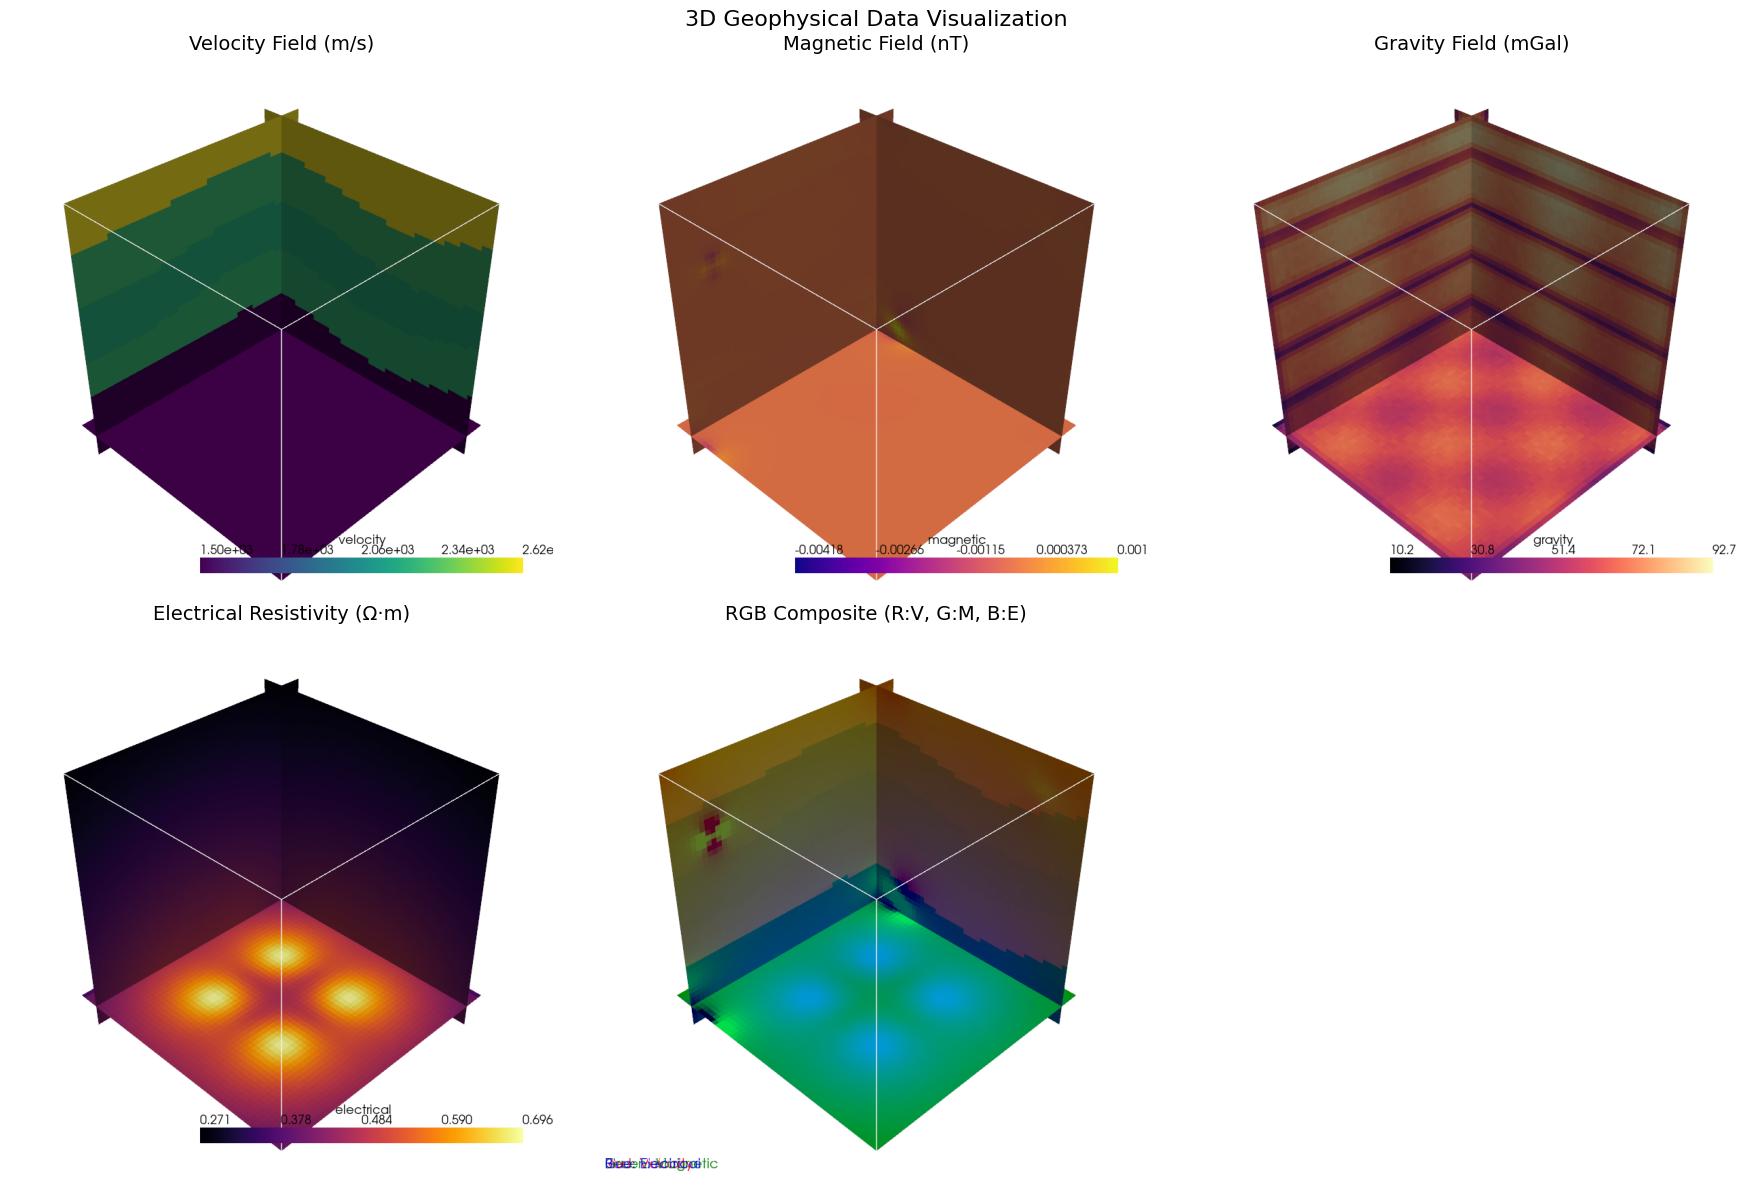


Visualization completed successfully!
The visualization shows:
- Velocity field (seismic wave speed)
- Magnetic field (magnetic susceptibility)
- Gravity field (density variations)
- Electrical field (resistivity/conductivity)
- RGB composite combining all three properties


In [28]:
main()